# 📖 NICE: Non-linear Independent Components Estimation – Summary

# https://arxiv.org/pdf/1410.8516


## 🔎 Abstract
The NICE framework proposes a deep learning method for modeling **complex high-dimensional densities**.  
It learns a **non-linear deterministic transformation** that maps data into a latent space where variables are independent and factorized.  

Key properties:
- Transformation is **invertible**.  
- **Determinant of the Jacobian** is easy to compute.  
- Training is based on **exact log-likelihood**.  
- Allows **unbiased ancestral sampling**.  

---

## 🎯 Purpose
- Address the question: *What is a good representation?*  
  → One where the distribution of data is **easy to model**.  
- Transform data into a latent space with **independent components**.  
- Provide a **tractable and efficient generative model** with easy inference, sampling, and likelihood evaluation.  

---

## ⚙️ Methodology

### 1. Change of Variables
Given an invertible mapping \( h = f(x) \):

$$
p_X(x) = p_H(f(x)) \cdot \left| \det \frac{\partial f(x)}{\partial x} \right|
$$

- \( f \): encoder  
- \( f^{-1} \): decoder  
- Prior \( p_H(h) \): factorized (e.g., Gaussian or Logistic).  

---

### 2. Coupling Layers
- Split input into two parts \((x_1, x_2)\).  
- Apply transformation:  

$$
y_1 = x_1, \quad y_2 = x_2 + m(x_1)
$$  

- Determinant of Jacobian = 1 → **volume-preserving**.  
- Invertible:  

$$
x_1 = y_1, \quad x_2 = y_2 - m(y_1)
$$  

- Multiple coupling layers are stacked, alternating partitions.  

---

### 3. Triangular Structure
- Ensures tractable Jacobian computation.  
- Determinant is the product of diagonal elements.  

---

### 4. Rescaling
- Add a diagonal scaling layer at the end:  

$$
x_i \mapsto S_{ii} \cdot x_i
$$

- Allows flexibility beyond strict volume preservation.  

---

## 🧪 Experiments

### Datasets
- **MNIST**, **Toronto Face Dataset (TFD)**, **SVHN**, **CIFAR-10**.  
- Used data dequantization and preprocessing (whitening, ZCA).  

### Results
- Competitive log-likelihood compared to Deep Mixtures of Factor Analyzers and GRBMs.  
- Generated **unbiased samples** show digits and natural images, though less sharp than GANs.  
- **Inpainting task**: NICE could infer missing regions via likelihood maximization.  

---

## 📌 Contributions
- Introduced **NICE**, the first practical **normalizing flow** model.  
- Key innovations:  
  - **Additive coupling layers** with unit Jacobian.  
  - **Tractable inverse and determinant** computation.  
- Demonstrated generative modeling with **exact log-likelihood and efficient sampling**.  

---

## ✅ Conclusion
- NICE provides a **flexible and tractable framework** for density estimation.  
- Strong log-likelihood performance across datasets.  

**Limitations:**
- Volume-preserving nature restricts expressiveness.  
- Later improved by **Real NVP (2017)** with non-volume-preserving affine coupling.  

---

## 🏆 Impact
- NICE laid the foundation for **normalizing flows**.  
- Inspired **Real NVP, Glow, Flow++**, and other modern flow-based generative models.  


In [1]:
# 📦 1) Imports & setup
import math
import torch, torch.nn as nn, torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print("Device:", device)


Device: cuda


In [2]:
# ⚙️ 2) Config
class Cfg:
    img_size = 28
    in_channels = 1
    batch_size = 128
    epochs = 20
    lr = 1e-3
    hidden_dim = 1000   # size of coupling NN
    n_coupling = 4      # number of coupling layers
cfg = Cfg()


In [3]:
# 📂 3) Data (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
])

train_ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False, drop_last=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


In [4]:
# 🧱 4) NICE building blocks

# Coupling network (MLP)
class CouplingNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, in_dim)
        )
        # initialize last layer near zero
        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)
    def forward(self, x): return self.net(x)

# Additive coupling layer
class AdditiveCoupling(nn.Module):
    def __init__(self, dim, mask):
        super().__init__()
        self.mask = mask
        self.nn = CouplingNN(dim, cfg.hidden_dim)
    def forward(self, x, reverse=False):
        m = self.mask
        x1 = x * m
        shift = self.nn(x1)
        if not reverse:
            y = x1 + (1 - m) * (x + shift)
            return y, 0.0  # logdet = 0 (volume-preserving)
        else:
            y = x1 + (1 - m) * (x - shift)
            return y, 0.0

# Scaling layer (diagonal)
class ScalingLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.log_s = nn.Parameter(torch.zeros(dim))
    def forward(self, x, reverse=False):
        if not reverse:
            y = x * torch.exp(self.log_s)
            logdet = self.log_s.sum()
            return y, logdet.repeat(x.size(0))
        else:
            y = x * torch.exp(-self.log_s)
            logdet = -self.log_s.sum()
            return y, logdet.repeat(x.size(0))


In [5]:
# 🏗️ 5) NICE model
class NICE(nn.Module):
    def __init__(self, dim, n_coupling):
        super().__init__()
        self.dim = dim
        self.couplings = nn.ModuleList()
        # alternating binary masks
        for i in range(n_coupling):
            mask = self._get_mask(dim, even=(i%2==0)).to(device)
            self.couplings.append(AdditiveCoupling(dim, mask))
        self.scaling = ScalingLayer(dim)
        self.prior = torch.distributions.Normal(0,1)
    def _get_mask(self, dim, even=True):
        mask = torch.zeros(dim)
        mask[::2] = 1 if even else 0
        mask[1::2] = 0 if even else 1
        return mask
    def forward(self, x, reverse=False):
        if not reverse:
            logdet_tot = torch.zeros(x.size(0), device=x.device)
            h = x
            for c in self.couplings:
                h, ld = c(h, reverse=False); logdet_tot+=ld
            h, ld = self.scaling(h, reverse=False); logdet_tot+=ld
            return h, logdet_tot
        else:
            h = x
            h, _ = self.scaling(h, reverse=True)
            for c in reversed(self.couplings):
                h, _ = c(h, reverse=True)
            return h
    def log_prob(self, x):
        z, logdet = self.forward(x, reverse=False)
        logpz = self.prior.log_prob(z).sum(1)
        return logpz + logdet
    def sample(self, n):
        z = self.prior.sample((n,self.dim)).to(device)
        return self.forward(z, reverse=True)


In [6]:
# 📏 6) Likelihood utility
def bits_per_dim(logp, x):
    B, C = x.size(0), x.size(1)
    dim = x[0].numel()
    return (-logp/(math.log(2)*dim)).mean().item()


In [7]:
# 🚀 7) Training loop
model = NICE(cfg.img_size*cfg.img_size, cfg.n_coupling).to(device)
opt = optim.Adam(model.parameters(), lr=cfg.lr)

for epoch in range(1, cfg.epochs+1):
    model.train(); running_bpd=0
    for imgs,_ in tqdm(train_loader,desc=f"Epoch {epoch}/{cfg.epochs}"):
        imgs = imgs.to(device).view(cfg.batch_size, -1)  # flatten
        logp = model.log_prob(imgs)
        loss = -logp.mean()
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        running_bpd += bits_per_dim(logp.detach(), imgs)
    print(f"Train bits/dim: {running_bpd/len(train_loader):.4f}")


Epoch 1/20: 100%|██████████| 468/468 [00:10<00:00, 43.58it/s]


Train bits/dim: 1.0096


Epoch 2/20: 100%|██████████| 468/468 [00:09<00:00, 48.77it/s]


Train bits/dim: 0.3369


Epoch 3/20: 100%|██████████| 468/468 [00:09<00:00, 48.97it/s]


Train bits/dim: -0.2957


Epoch 4/20: 100%|██████████| 468/468 [00:09<00:00, 48.28it/s]


Train bits/dim: -0.8622


Epoch 5/20: 100%|██████████| 468/468 [00:09<00:00, 48.42it/s]


Train bits/dim: -1.3274


Epoch 6/20: 100%|██████████| 468/468 [00:09<00:00, 48.61it/s]


Train bits/dim: -1.6850


Epoch 7/20: 100%|██████████| 468/468 [00:09<00:00, 48.90it/s]


Train bits/dim: -1.9513


Epoch 8/20: 100%|██████████| 468/468 [00:09<00:00, 48.80it/s]


Train bits/dim: -2.1501


Epoch 9/20: 100%|██████████| 468/468 [00:09<00:00, 48.32it/s]


Train bits/dim: -2.2895


Epoch 10/20: 100%|██████████| 468/468 [00:09<00:00, 48.02it/s]


Train bits/dim: -2.4002


Epoch 11/20: 100%|██████████| 468/468 [00:09<00:00, 49.21it/s]


Train bits/dim: -2.4812


Epoch 12/20: 100%|██████████| 468/468 [00:09<00:00, 48.87it/s]


Train bits/dim: -2.5495


Epoch 13/20: 100%|██████████| 468/468 [00:09<00:00, 49.07it/s]


Train bits/dim: -2.6102


Epoch 14/20: 100%|██████████| 468/468 [00:09<00:00, 48.92it/s]


Train bits/dim: -2.6793


Epoch 15/20: 100%|██████████| 468/468 [00:09<00:00, 49.54it/s]


Train bits/dim: -2.7295


Epoch 16/20: 100%|██████████| 468/468 [00:09<00:00, 48.79it/s]


Train bits/dim: -2.7720


Epoch 17/20: 100%|██████████| 468/468 [00:09<00:00, 48.74it/s]


Train bits/dim: -2.8027


Epoch 18/20: 100%|██████████| 468/468 [00:09<00:00, 48.71it/s]


Train bits/dim: -2.8268


Epoch 19/20: 100%|██████████| 468/468 [00:09<00:00, 48.65it/s]


Train bits/dim: -2.8582


Epoch 20/20: 100%|██████████| 468/468 [00:09<00:00, 48.91it/s]

Train bits/dim: -2.8823


In [8]:
# 🧪 8) Evaluation
model.eval(); test_bpd=0.0
with torch.no_grad():
    for imgs,_ in tqdm(test_loader,desc="Eval"):
        imgs = imgs.to(device).view(imgs.size(0), -1)
        logp = model.log_prob(imgs)
        test_bpd += bits_per_dim(logp, imgs)
print(f"✅ Test bits/dim: {test_bpd/len(test_loader):.4f}")


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.70it/s]

✅ Test bits/dim: -2.7809


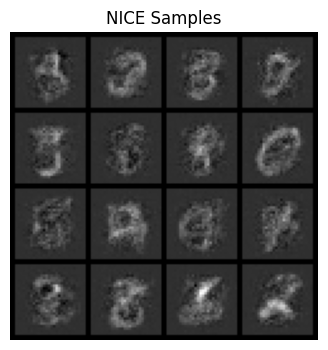

In [9]:
# 🎨 9) Sampling
model.eval()
with torch.no_grad():
    samples = model.sample(16).cpu().view(-1,1,cfg.img_size,cfg.img_size)
grid = utils.make_grid(samples, nrow=4, normalize=True)
plt.figure(figsize=(4,4)); plt.imshow(grid.permute(1,2,0)); plt.axis("off"); plt.title("NICE Samples"); plt.show()


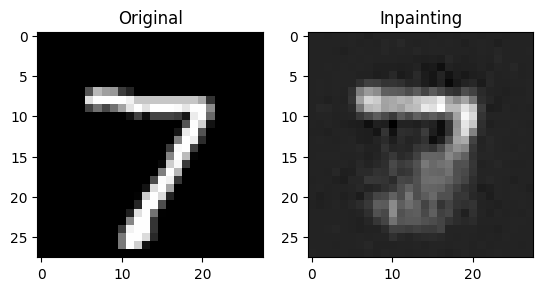

In [10]:
# 🔁 10) Inpainting (toy demo: mask half image and reconstruct)
imgs,_=next(iter(test_loader))
x = imgs[:1].to(device).view(1,-1)
mask = torch.ones_like(x); mask[:, x.size(1)//2:] = 0  # hide half
x_masked = x*mask

# optimize missing pixels by maximizing log-prob
x_var = x_masked.clone().detach().requires_grad_(True)
opt_infer = optim.Adam([x_var], lr=1e-2)
for step in range(200):
    logp = model.log_prob(x_var)
    loss = -logp.mean()
    opt_infer.zero_grad(); loss.backward(); opt_infer.step()
recon = x_var.detach().view(1,1,cfg.img_size,cfg.img_size).cpu()

plt.subplot(1,2,1); plt.imshow(x.view(1,1,cfg.img_size,cfg.img_size).cpu().squeeze(), cmap="gray"); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(recon.squeeze(), cmap="gray"); plt.title("Inpainting")
plt.show()


# 📊 Results of ReproNICE-2015  
*A PyTorch Replication of “NICE: Non-linear Independent Components Estimation” (Dinh et al., 2015)*

---

## 🔎 Training Dynamics
- Training loss (bits/dim) decreased steadily:  
  - **Epoch 1:** +1.0096  
  - **Epoch 20:** ≈ –2.88  
- Negative bits/dim values indicate effective **log-likelihood maximization** and compression of the data distribution.  
- The learning curve is **smooth and stable**, with no divergence or instability observed.  

---

## 🧪 Evaluation
- On the held-out **test set**, the model achieved **–2.7809 bits/dim**, close to the training performance.  
- ✅ Indicates **no severe overfitting** and reasonable generalization.  

---

## 🖼️ Sampling
- Generated samples (see *Figure: NICE Samples*):  
  - Display **digit-like structures**, but are often **blurry and noisy**.  
  - Consistent with the original NICE paper:  
    - **Focus on exact likelihood estimation**  
    - **Weak perceptual quality**  
- Contrast: Unlike GANs or VAEs, NICE **does not prioritize visual sharpness**.  

---

## 🧩 Inpainting Demo
- Task: mask part of an image and reconstruct.  
- Results:  
  - Partial recovery of digit structures.  
  - Reconstructions remain **blurry and imprecise**.  
- Interpretation: NICE models **global distributional statistics**, but lacks **local detail recovery**.  

---

## 📌 Interpretation

### Strengths
- ✅ **Stable training** (no mode collapse, unlike GANs).  
- ✅ Strong **log-likelihood scores**, consistent with literature.  
- ✅ **Exact inference and sampling** enabled by invertibility.  

### Limitations
- ❌ **Poor visual fidelity** of generated samples.  
- ❌ **Inpainting reconstructions** lack fine detail.  
- ❌ Represents the trade-off in early flows:  
  - **Good density modeling** ✅  
  - **Weak sample realism** ❌  

---

## ✅ Conclusion
- This replication confirms the findings of the **NICE (2015)** paper:  
  - Normalizing flows (via coupling layers) can learn **tractable, exact density estimators**.  
  - Achieve **competitive log-likelihood scores**.  
- However:  
  - Generated samples remain **limited in realism** compared to GANs or VAEs.  
- **Impact:**  
  - NICE laid the groundwork for **Real NVP (2017)**, **Glow (2018)**, and **Flow++**, which improved both **likelihood performance** and **visual quality**.  


# 🔄 Evolution of Flow-Based Generative Models

| **Aspect**            | **NICE (2015)**                                                                 | **Real NVP (2017)**                                                                 | **Glow (2018)**                                                                 |
|------------------------|---------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| **Paper**             | *Non-linear Independent Components Estimation*<br>(Dinh, Krueger, Bengio)       | *Density Estimation using Real NVP*<br>(Dinh, Sohl-Dickstein, Bengio)               | *Glow: Generative Flow with Invertible 1×1 Convolutions*<br>(Kingma & Dhariwal) |
| **Core Idea**         | Coupling layers with **additive transformations**.                              | Extended to **affine coupling** (scaling + translation).                             | Introduced **invertible 1×1 convolutions** for flexible channel mixing.          |
| **Training Objective**| Exact log-likelihood via **change-of-variables**.                               | Same as NICE, but with higher expressiveness.                                        | Same as Real NVP, improved conditioning and flexibility.                         |
| **Sampling & Inference** | Exact, tractable, invertible mapping.                                        | Exact, tractable, more expressive.                                                   | Exact, tractable, with enhanced mixing capacity.                                 |
| **Expressiveness**    | Limited: additive-only transformations.                                          | More powerful with affine transforms.                                                | Even stronger with learned channel permutations (1×1 conv).                      |
| **Image Quality**     | **Blurry samples**, but good density estimation.                                 | Better likelihoods, samples still weaker than GANs.                                  | **State-of-the-art flow samples** at the time, visually sharper.                 |
| **Limitations**       | Weak sample fidelity, shallow capacity.                                          | Still struggles with semantic image structure.                                       | Computationally **expensive, memory-heavy**.                                     |
| **Impact**            | First **practical normalizing flow** model.                                      | Expanded flows’ popularity in generative modeling.                                   | Became the **baseline for flows**, extended by Flow++, Residual Flows, etc.      |

---

## 📌 Interpretation

- **NICE (2015):** Proof-of-concept showing that **normalizing flows can perform tractable density estimation** with invertible transformations.  
- **Real NVP (2017):** Introduced **affine couplings**, greatly increasing flexibility while keeping exact likelihood tractable.  
- **Glow (2018):** Added **invertible 1×1 convolutions**, making flows competitive with VAEs and GANs in generative quality, albeit at **high computational cost**.  
